### Predicting transfer value of football players using ML (statistics and additional attributes)

In [2]:
# Importing relevant libaries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup, NavigableString, Tag
import os


c:\Users\olive\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [148]:
#Specify relevant seasons and leagues
years = ['2017-2018','2018-2019','2019-2020','2020-2021','2021-2022']
leagues = ['spanish-la-liga','italian-serie-a','german-bundesliga','english-premier-league','rest-of-europe']
stats = ['stats_standard','stats_passing','stats_defense']
stats_to_keep = ['Player','Nation','Pos','Squad','Age','MP','Starts','Min','90s','Gls','Ast','G-PK','CrdY','CrdR','Cmp%','KP','1/3','PPA','CrsPA',
'Prog','Tkl','TklW','Int','Err','Blocks','Tkl%','Year']

#Test
years_test = ['2017-2018','2018-2019']
leagues_test = ['english-premier-league']
stats_test = ['stats_passing']

In [149]:
def scrape(driver,id,id_):
    '''
    Sets up a function for scraping data based on a given driver

    args: driver (defines which driver to scrape from)
    '''

    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id)

    columns_html = table_node.thead.find_all('th')
        # Extract the text
    columns = []
    for col in columns_html:
        columns.append(col.text)

    if id_ == 'standard':
        columns = columns[7:]
    else:
        columns = columns[8:]

    rows_list = table_node.tbody.find_all('tr')

    data = []
    for row_node in rows_list:
        # if (rows_list.index(row_node) % 25 == 0):
        try:
            row = []
            for child in row_node.children:
                row.append(child.text)
            data.append(row)
        except:
            pass
    
    return columns, data

def clean_statistics(columns,data,period):
    df_out = pd.DataFrame(data,columns=columns)\
        .iloc[:,:-1]\
        .assign(Nation= lambda x: x['Nation'].str.split(' ').str[1],
            Pos = lambda x: x['Pos'].str.split(',').str[0], 
            Comp = lambda x: x['Comp'].str.split(None,1).str[1],
            # Pos = lambda x: pd.Categorical(x['Pos']),
            Squad = lambda x: pd.Categorical(x['Squad']),
            Year = period[0:4])
            # Nation = lambda x: pd.Categorical(x['Nation']))

    return df_out

In [150]:
def get_stats(periods,stats):
    df_list = []
    dict = {}

    for id in stats:
        id = id
        id_ = id.split('_')[-1]

        df_stats_ = []
        for period in periods:
            time.sleep(10)
            if id.split('_')[-1] == 'standard':
                url = f'https://fbref.com/en/comps/Big5/{period}/stats/players/{period}-Big-5-European-Leagues-Stats'
            else:
                url = f'https://fbref.com/en/comps/Big5/{period}/{id_}/players/{period}-Big-5-European-Leagues-Stats'
            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            time.sleep(3)
            cookie = driver.find_element(By.CLASS_NAME,'qc-cmp2-summary-buttons').click()

            columns, data = scrape(driver,id,id_)

            df_stats_.append(clean_statistics(columns, data, period))

        df_concat = pd.concat(df_stats_)

        # vars()[id] = pd.concat(df_stats_)
        dict[id] = df_concat
        # print(f'Number of observations in main dataset is: {len(main_df)}')
    
    return dict


In [17]:
stats_dict = get_stats(years_test,stats)

<ipython-input-16-10da1e3cc0dd>:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver


In [151]:
def merge_stats(dict):
    main_df = pd.DataFrame()

    keys, values = [list(x) for x in zip(*dict.items())]
    for key in keys:
        df_ = values[keys.index(key)]\
            .assign(Year = lambda x: pd.to_datetime(x['Year'],format='%Y'))


        if main_df.empty:
            main_df = df_
        else:
            main_df = main_df.merge(df_, how='left', on=['Player','Year','Squad'])

    # Clean column by removing duplicates denoted by _y
    main_df.drop(main_df.columns[main_df.columns.str.contains('_y')], axis=1, inplace=True)

    # Rename instances where _x appears back to the original  
    col_list = list(main_df.columns)
    col_list_ = []
    for col in col_list:
        col_list_.append(col.replace('_x',''))
    main_df.columns = col_list_


    main_df = main_df.loc[:, ~main_df.columns.duplicated()]
    main_df.drop('Rk',axis=1,inplace=True)
    main_df['Year']= pd.DatetimeIndex(main_df['Year']).year
    main_df = main_df[stats_to_keep]

    return main_df

In [152]:
df_all_stats = merge_stats(get_stats(years_test,stats))


<ipython-input-150-2060a9c5914f>:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver


In [153]:
df_all_stats.to_excel('year.xlsx')

In [ ]:
df_list = []
id = 'stats_passing'
url = 'https://fbref.com/en/comps/Big5/2018-2019/passing/players/2018-2019-Big-5-European-Leagues-Stats'
driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
driver.get(url)
time.sleep(3)
cookie = driver.find_element(By.CLASS_NAME,'qc-cmp2-summary-buttons').click()

soup = BeautifulSoup(driver.page_source, 'lxml')
table_node = soup.find(id=id)

columns_html = table_node.thead.find_all('th')
    # Extract the text
columns = []
for col in columns_html:
    columns.append(col.text)
# columns = columns[8:]
print(len(columns))
rows_list = table_node.tbody.find_all('tr')

data = []
for row_node in rows_list:
    # if (rows_list.index(row_node) % 25 == 0):
    try:
        row = []
        for child in row_node.children:
            row.append(child.text)
        data.append(row)
    except:
        pass

# df_list.append(clean_statistics(columns, data, years_test))

df_out = pd.DataFrame(data,columns=columns)\
    .iloc[:,:-1]\
    .assign(Nation= lambda x: x['Nation'].str.split(' ').str[1],
        Pos = lambda x: x['Pos'].str.split(',').str[0], 
        Comp = lambda x: x['Comp'].str.split(None,1).str[1],
        # Pos = lambda x: pd.Categorical(x['Pos']),
        Squad = lambda x: pd.Categorical(x['Squad']))
        # Year = period[0:4])
# time.sleep(10)

# main_df = pd.concat(df_list)
# print(f'Number of observations in main dataset is: {len(main_df)}')
# return main_df




In [ ]:
test = get_standard_stats(years_test,stats_test)

In [5]:
df_stats['Year']= pd.to_datetime(df_stats['Year'], format='%Y')
df_stats['Year']= pd.DatetimeIndex(df_stats['Year']).year


In [122]:
def scrape_transferprice(driver,id):
    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id)

    columns_html = table_node.thead.find_all('th')
        # Extract the text
    transfer_columns = []
    for col in columns_html:
        transfer_columns.append(col.text)

    rows_list = table_node.tbody.find_all('tr')

    transfer_data = []
    for row_node in rows_list:
        row = []
        for child in row_node.children:
            try:
                row.append(child.text)
            except:
                pass
        transfer_data.append(row)
    
    return transfer_columns, transfer_data

def clean_transfer(columns,data,period):    
    transfer_df = pd.DataFrame(data, columns=columns)\
                .assign(When = lambda x: x['When'].str.split(' ').str[0],
                    Price = lambda x: x['Price'].str.split('(?:(.*\d))?(?:([a-zA-Z]+))?').str[1],
                    Player = lambda x: x['Player'].str.rsplit(' ').str[:-1].apply(' '.join),
                    Year = int(period[0:4])-1)\
                .query("When != 'Jan'")\
                .replace(to_replace='None', value=np.nan).dropna()

    transfer_df.drop(transfer_df.columns[[0,1,4]],axis=1, inplace=True)


    return transfer_df                         

In [123]:
def get_transferprice(leagues,years):
    id = 'epl'
    df_transferprice = []
    for league in leagues:

        df_transferprice_ = []
        
        for periods in years:
            url = f'https://www.soccernews.com/soccer-transfers/{league}-transfers-{periods}/'
            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            # time.sleep(3)
            # cookie = driver.find_element(By.ID,'cn-accept-cookie').click()
            
            # Get data
            columns_transfer, transfer_data = scrape_transferprice(driver,id)

            df_transferprice_.append(clean_transfer(columns_transfer,transfer_data,periods))
    
        df_transferprice.append(pd.concat(df_transferprice_))

    return pd.concat(df_transferprice)
#     main_transfer = pd.concat(df_transferprice)
#     print(f'Number of observations in main dataset is: {len(main_transfer)}')

#     return main_transfer

# main_transfer_df = get_transferprice(leagues_test,years)

In [125]:
df_transferprice = get_transferprice(leagues,years_test)

<ipython-input-123-3900a32a9103>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-123-3900a32a9103>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-123-3900a32a9103>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-123-3900a32a9103>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-123-3900a32a9103>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-123-3900a3

In [126]:
df_transferprice.to_csv('Transfer.csv')

In [135]:
df_transferprice['Year']= pd.to_datetime(df_transferprice['Year'], format='%Y')
df_transferprice['Year']= pd.DatetimeIndex(df_transferprice['Year']).year
df_transferprice.tail(10)

,Player,From,To,Price,Year
126,Jonathan Panzo,Chelsea,Monaco,2.8,2017
128,Pele,Rio Ave,Monaco,9,2017
130,Yuto Nagatomo,Inter Milan,Galatasaray,2.25,2017
132,Dusan Tadic,Southampton,Ajax,11.3,2017
133,Emiliano Viviano,Sampdoria,Sporting CP,1.8,2017
135,Willem Geubbels,Olympique Lyon,AS Monaco,18,2017
137,Saidy Janko,St. Etienne,FC Porto,2.7,2017
138,Angelino,Manchester City,PSV Eindhoven,5.7,2017
140,Danilo,Braga,Nice,8,2017
142,Samuel Grandsir,Troyes,AS Monaco,2.7,2017


### Trying to merge transfer data with statistics

### **Hvis du har mod på det må du meget gerne kigge på dette, Carl Philip**

De to datasæt skal merges så vi ender med et samlet datasæt med stats og transferpris

In [137]:
test_stats_merge = df_all_stats.loc[df_all_stats['Player'] == 'Fabinho']

In [138]:
test_stats_merge

,Player,Nation,Pos,Squad,Age,MP,Starts,Min,90s,Gls,...,1/3,PPA,CrsPA,Prog,Tkl,TklW,Int,Err,Blocks,Tkl%
778,Fabinho,BRA,MF,Monaco,23,34,34,"3,060",34.0,7,...,210,28,1,181,96,61,39,0,50,29.9
3456,Fabinho,BRA,MF,Liverpool,24,28,21,"2,017",22.4,1,...,159,22,2,127,59,35,30,0,39,34.5


In [139]:
test_transfer_merge = df_transferprice.loc[df_transferprice['Player'] == 'Fabinho']

In [140]:
test_transfer_merge

,Player,From,To,Price,Year
138,Fabinho,AS Monaco,Liverpool,45,2017


In [141]:
test_merge_df = test_stats_merge.merge(test_transfer_merge, how='left', on=['Player','Year'])

KeyError: 'Year'

In [145]:
#new_df = test_stats_merge.merge(test_transfer_merge, how='left', left_on=['Player','Year'], right_on=['Price'])

new_df = df_all_stats.merge(df_transferprice, how='left', on=['Player','Year'])
new_df.dropna(subset=['Price'],inplace=True)

# Nu skal der bare droppes de rows med NaN i price

KeyError: 'Year'

In [48]:
new_df.to_csv('til Carl Philip.csv')

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,npxG+xA,xG,xA,xG+xA,npxG,npxG+xA,Year,From,To,Price
0,779,Fabinho,BRA,MF,Monaco,Ligue 1,23,1993,34,34,...,6.2,0.16,0.11,0.27,0.07,0.18,2017,AS Monaco,Liverpool,45
1,766,Fabinho,BRA,MF,Liverpool,Premier League,24,1993,28,21,...,2.1,0.04,0.06,0.09,0.04,0.09,2018,NaN,NaN,NaN


### Celle til leg med plots (Carl Philip)

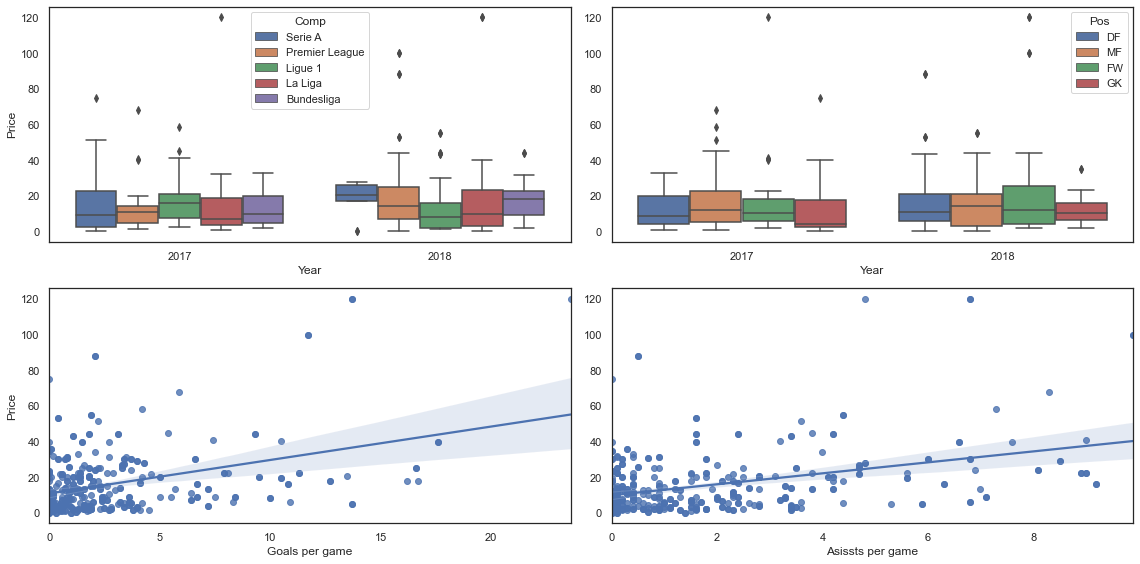

In [110]:
# Import graphical packages
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_theme(style="white")

# Data cleaning for copy paste
new_df=pd.read_csv(Path.cwd() / 'til Carl Philip.csv')
new_df['Price (m)'] = new_df['Price'].str.replace(',','').astype(float)
new_df['Price (m)'] = (new_df['Price (m)'] > 500) * new_df['Price (m)'] * 1/1000000 + (new_df['Price (m)'] <= 500) * new_df['Price (m)']

# Define plot
f,ax = plt.subplots(2,2, figsize=(16,8))

# First row
sns.boxplot(x='Year', y='Price (m)', data=new_df, hue="Comp", ax=ax[0, 0]).set( xlabel = "Year", ylabel = "Price")
sns.boxplot(x='Year', y='Price (m)', data=new_df, hue="Pos", ax=ax[0, 1]).set( xlabel = "Year", ylabel = "")

# Second row
sns.regplot(x='xG', y='Price (m)', data=new_df, ax=ax[1, 0]).set( xlabel = "Goals per game", ylabel = "Price")
sns.regplot(x='xA', y='Price (m)', data=new_df, ax=ax[1, 1]).set( xlabel = "Asissts per game", ylabel = "")
f.tight_layout()

# Create path to save figure
fp_figs = Path.cwd() / 'figs'  
# Use the Path object to actually create the subfolder
Path.mkdir(fp_figs, exist_ok=True)  
# Export for paper
plt.savefig('figs/pic1.png')


